In [1]:
import tensorflow as tf
import numpy as np

from six.moves import xrange
from noMnist_dataset import *
    
flags = tf.app.flags
flags.DEFINE_boolean('fake_data', False, 'the fake data used for unit testing')
flags.DEFINE_integer('max__steps', 200, 'the number of epoch')
flags.DEFINE_integer('learning__rate', 0.0001, 'the learning rate of the model')
flags.DEFINE_integer('dropout', 0.9, 'the value of the droup out')
flags.DEFINE_string('data__dir', '/input_data', 'the direction of the data')
flags.DEFINE_string('log__dir', 'D:/Data Minning/train_code/train/noMnist/model/', 'the direction the log file')
FLAGS = flags.FLAGS

def train():
    
    image_size = 28  # Pixel width and height.
    pixel_depth = 255.0  # Number of levels per pixel.

    def load_letter(folder, min_num_images):
        """Load the data for a single letter label."""
        image_files = os.listdir(folder)
        dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
        print(folder)
        num_images = 0
        for image in image_files:
            image_file = os.path.join(folder, image)
            try:
                image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
                if image_data.shape != (image_size, image_size):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[num_images, :, :] = image_data
                num_images = num_images + 1
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
        dataset = dataset[0:num_images, :, :]
        if num_images < min_num_images:
            raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
        print('Full dataset tensor:', dataset.shape)
        print('Mean:', np.mean(dataset))
        print('Standard deviation:', np.std(dataset))
        return dataset
        
    def maybe_pickle(data_folders, min_num_images_per_class, force=False):
        dataset_names = []
        for folder in data_folders:
            set_filename = folder + '.pickle'
            dataset_names.append(set_filename)
            if os.path.exists(set_filename) and not force:
                # You may override by setting force=True.
                print('%s already present - Skipping pickling.' % set_filename)
            else:
                print('Pickling %s.' % set_filename)
                dataset = load_letter(folder, min_num_images_per_class)
                try:
                    with open(set_filename, 'wb') as f:
                        pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
                except Exception as e:
                    print('Unable to save data to', set_filename, ':', e)
  
        return dataset_names

    train_datasets = maybe_pickle(train_folders, 45000)
    test_datasets = maybe_pickle(test_folders, 1800)


    def make_arrays(nb_rows, img_size):
        if nb_rows:
            dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
            label = np.ndarray(nb_rows, dtype=np.int32)
        else:
            dataset, label = None, None
        return dataset, label

    def merge_datasets(pickle_files, train_size, valid_size=0):
        num_classes = len(pickle_files)
        valid_dataset, valid_labels = make_arrays(valid_size, image_size)
        train_dataset, train_labels = make_arrays(train_size, image_size)
        vsize_per_class = valid_size // num_classes
        tsize_per_class = train_size // num_classes
    
        start_v, start_t = 0, 0
        end_v, end_t = vsize_per_class, tsize_per_class
        end_l = vsize_per_class+tsize_per_class
        for label, pickle_file in enumerate(pickle_files):       
            try:
                with open(pickle_file, 'rb') as f:
                    letter_set = pickle.load(f)
                    np.random.shuffle(letter_set)
                    if valid_dataset is not None:
                        valid_letter = letter_set[:vsize_per_class, :, :]
                        valid_dataset[start_v:end_v, :, :] = valid_letter
                        valid_labels[start_v:end_v] = label
                        start_v += vsize_per_class
                        end_v += vsize_per_class
                    
                    train_letter = letter_set[vsize_per_class:end_l, :, :]
                    train_dataset[start_t:end_t, :, :] = train_letter
                    train_labels[start_t:end_t] = label
                    start_t += tsize_per_class
                    end_t += tsize_per_class
            except Exception as e:
                print('Unable to process data from', pickle_file, ':', e)
                raise
    
        return valid_dataset, valid_labels, train_dataset, train_labels
            
            
    train_size = 200000
    valid_size = 10000
    test_size = 10000

    valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
    _, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

    print('Training:', train_dataset.shape, train_labels.shape)
    print('Validation:', valid_dataset.shape, valid_labels.shape)
    print('Testing:', test_dataset.shape, test_labels.shape)

    def randomize(dataset, labels):
        permutation = np.random.permutation(labels.shape[0])
        shuffled_dataset = dataset[permutation,:,:]
        shuffled_labels = labels[permutation]
        return shuffled_dataset, shuffled_labels

    train_dataset, train_labels = randomize(train_dataset, train_labels)
    test_dataset, test_labels = randomize(test_dataset, test_labels)
    valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

    pickle_file = os.path.join(data_root, 'notMNIST.pickle')

    try:
        f = open(pickle_file, 'wb')
        save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
    
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:', statinfo.st_size)

    
    image_size = 28
    num_labels = 10
    
    def reformat(dataset, lables):
        dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
        lables = (np.arange(num_labels) == lables[:,None]).astype(np.float32)
        return dataset, lables
    
    print('Training:', train_dataset.shape, train_labels.shape)
    print('Validation:', valid_dataset.shape, valid_labels.shape)
    print('Testing:', test_dataset.shape, test_labels.shape)
    train_dataset, train_labels = reformat(train_dataset, train_labels)
    valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
    test_dataset, test_labels = reformat(test_dataset, test_labels)
    print('Training:', train_dataset.shape, train_labels.shape)
    print('Validation:', valid_dataset.shape, valid_labels.shape)
    print('Testing:', test_dataset.shape, test_labels.shape)

    sess = tf.InteractiveSession()
    # Create a multilayer model.

    # Input placeholders
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, 784], name='x_input')
        y_ = tf.placeholder(tf.float32, [None, 10], name='y_input')

    with tf.name_scope('input_reshape'):
        image = tf.reshape(x, [-1, 28, 28, 1])
        tf.summary.image('image', image, 10)

    # We can't initialize these variables to 0 - the network will get stuck.
    def weight_variable(shape):
        """Create a weight variable with appropriate initialization."""
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        """Create a bias variable with appropriate initialization."""
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def variable_summaries(var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

    def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
        """Reusable code for making a simple neural net layer.
        It does a matrix multiply, bias add, and then uses relu to nonlinearize.
        It also sets up name scoping so that the resultant graph is easy to read,
        and adds a number of summary ops.
        """
        # Adding a name scope ensures logical grouping of the layers in the graph.
        with tf.name_scope(layer_name):
            # This Variable will hold the state of the weights for the layer
            with tf.name_scope('weights'):
                weights = weight_variable([input_dim, output_dim])
                variable_summaries(weights)
            with tf.name_scope('biases'):
                biases = bias_variable([output_dim])
                variable_summaries(biases)
            with tf.name_scope('Wx_plus_b'):
                preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
            activations = act(preactivate, name='activation')
            tf.summary.histogram('activations', activations)
            return activations

    hidden1 = nn_layer(x, 784, 500, 'layer1')

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        #tf.summary.scalar('druoput__keep_probability', keep_prob)
        dropped = tf.nn.dropout(hidden1, keep_prob)

    # Do not apply softmax activation yet, see below.
    y = nn_layer(dropped, 500, 10, 'layer2', act=tf.identity)

    with tf.name_scope('cross_entropy'):
        diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
        with tf.name_scope('total'):
            cross_entropy = tf.reduce_mean(diff)
        #tf.summary.scalar('cross_entropy', cross_entropy)

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(FLAGS.learning__rate).minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #tf.summary.scalar('accuracy', accuracy)

    # Merge all the summaries and write them out to /tmp/tensorflow/mnist/logs/mnist_with_summaries (by default)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.log__dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(FLAGS.log__dir + '/test')
    tf.global_variables_initializer().run()
    
    def get_batch_data(data,label,batch_size):
        start_index = np.random.randint(0, len(data) - batch_size)
        return data[start_index : start_index + batch_size], label[start_index : start_index + batch_size]
          
    # Train the model, and also write summaries.
    # Every 10th step, measure test-set accuracy, and write test summaries
    # All other steps, run train_step on training data, & add training summaries

    def feed_dict(train):
        """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
        if train or FLAGS.fake_data:
            xs, ys = get_batch_data(data = train_dataset, label = train_labels, batch_size = 100)
            k = FLAGS.dropout
        else:
            xs, ys = get_batch_data(data = test_dataset, label = test_labels, batch_size = 100)
            #xs, ys = test_dataset, test_labels
            k = 1.0
        return {x: xs, y_: ys, keep_prob: k}

    for i in range(FLAGS.max__steps):
        if i % 20 == 0:  # Record summaries and test-set accuracy
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('Accuracy at step %s: %s' % (i, acc))
        else:  # Record train set summaries, and train
            if i % 10 == 0:  # Record execution stats
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, _ = sess.run([merged, train_step],
                                      feed_dict=feed_dict(True),
                                      options=run_options,
                                      run_metadata=run_metadata)
                train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
                train_writer.add_summary(summary, i)
                print('Adding run metadata for', i)
            else:  # Record a summary
                summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
                train_writer.add_summary(summary, i)
                
    saver = tf.train.Saver()
    saver.save(sess, FLAGS.log__dir, global_step = i)
    
    train_writer.close()
    test_writer.close()


def main(_):
    if tf.gfile.Exists(FLAGS.log__dir):
        tf.gfile.DeleteRecursively(FLAGS.log__dir)
    tf.gfile.MakeDirs(FLAGS.log__dir)
    train()

          
if __name__ == '__main__':
    tf.app.run()


Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz
.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']
.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_lar

SystemExit: 

d:\python\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# import the related packages
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import sys
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import ndimage
from six.moves import xrange
from six.moves import cPickle as pickle
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve


# define some funtion to sample the code
def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
    last_percent_reported = percent
    
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
    # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception( 'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
    print(data_folders)
    return data_folders


def make_arrays(nb_rows, img_size):
    """Change the data and lables to the arrays """
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        label = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, label = None, None
    return dataset, label
    
def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    """Check the pickle file and load the pictures"""
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

def save_pickle():
    pickle_file = os.path.join(data_root, 'notMNIST.pickle')

    try:
        f = open(pickle_file, 'wb')
        save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
    
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:', statinfo.st_size)

def randomize(dataset, labels):
    """Random the datas and the lables"""
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
    
def reformat(dataset, lables):
    """Change the shape of the datasets and lables"""
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    lables = (np.arange(num_labels) == lables[:,None]).astype(np.float32)
    return dataset, lables
    
# We can't initialize these variables to 0 - the network will get stuck.
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)
    
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.
    It does a matrix multiply, bias add, and then uses relu to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
        tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
    return activations
 
def get_batch_data(data,label,batch_size):
    """Get the batch datas and the lables"""
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index : start_index + batch_size], label[start_index : start_index + batch_size]
    
def feed_dict(train):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train or FLAGS.fake_data:
        xs, ys = get_batch_data(data = train_dataset, label = train_labels, batch_size = 100)
        k = FLAGS.dropout
    else:
        xs, ys = get_batch_data(data = test_dataset, label = test_labels, batch_size = 100)
        #xs, ys = test_dataset, test_labels
        k = 1.0
    return {x: xs, y_: ys, keep_prob: k}

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz
.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']
.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_lar

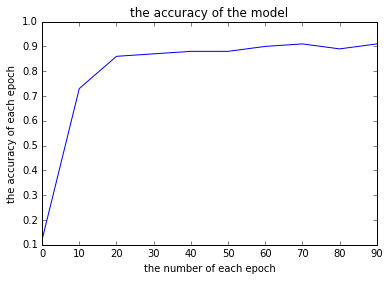

ending...
This whole code host 31 seconds...


SystemExit: 

d:\python\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
# import the related packages
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import sys
import time
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import ndimage
from six.moves import xrange
from scipy.misc import imsave
from six.moves import cPickle as pickle
from six.moves.urllib.request import urlretrieve

from function import *
#from noMnist_dataset import *


# define the changeable parameters
flags = tf.app.flags
#flags.DEFINE_boolean('fake__data', False, 'the fake data used for unit testing')
flags.DEFINE_integer('max__steps', 100, 'the number of epoch')
flags.DEFINE_integer('dropout', 0.8, 'the value of the droup out')
flags.DEFINE_integer('learning__rate', 0.001, 'the learning rate of the model')
flags.DEFINE_string('optimizer', 'adam', 'the optimizer of the model')
flags.DEFINE_string('data__dir', '/input_data', 'the direction of the data')
flags.DEFINE_string('log__dir', 'D:/Data Minning/train_code/train/noMnist/model/', 'the direction the log file')
FLAGS = flags.FLAGS
 
def choose_optimizer(name):
    if name == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(FLAGS.learning__rate)
    elif name == 'adam':
        optimizer = tf.train.AdamOptimizer(FLAGS.learning__rate)
    elif name == 'adag':
        optimizer = tf.train.AdagradOptimizer(FLAGS.learning__rate)
    elif name == 'adad':
        optimizer = tf.train.AdadeltaOptimizer(FLAGS.learning__rate)
    elif name == 'rmsp':
        optimizer = tf.train.RMSPropOptimizer(FLAGS.learning__rate)
    else:
        print('please add you optimizer...')
        raise Exception('Error...')
    return optimizer


def train():
    
    start_time = time.time()
    num_classes = 10          # The class of the directions
    np.random.seed(133)         

    train_size = 200000       # The size of training datasets
    valid_size = 10000        # The size of validation datasets
    test_size = 10000         # The size of testing datasets
    
    image_size = 28           # Pixel width and height.
    pixel_depth = 255.0       # Number of levels per pixel.
    num_labels = 10           # The number of lables
    
    url = 'http://commondatastorage.googleapis.com/books1000/'
    last_percent_reported = None
    data_root = '.'           # Change me to store data elsewhere
    
    # Download the notMnist datasets(tar file)
    train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
    test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)
    
    # Tar the file to the folders
    train_folders = maybe_extract(train_filename)
    test_folders = maybe_extract(test_filename)
    
    # Change the file to the pickle file
    train_datasets = maybe_pickle(train_folders, 45000)
    test_datasets = maybe_pickle(test_folders, 1800)     
           
    valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
    _, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)
    
    
    # Shuffer the datasets
    train_dataset, train_labels = randomize(train_dataset, train_labels)
    test_dataset, test_labels = randomize(test_dataset, test_labels)
    valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
    
    # Save the pickle file and check it
    save_pickle(train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels)
    
    # Change the format of the datasets
    train_dataset, train_labels = reformat(train_dataset, train_labels)
    valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
    test_dataset, test_labels = reformat(test_dataset, test_labels)
    print('Training:', train_dataset.shape, train_labels.shape)
    print('Validation:', valid_dataset.shape, valid_labels.shape)
    print('Testing:', test_dataset.shape, test_labels.shape)
    
    # Create a Session layer
    sess = tf.InteractiveSession()

    # Input placeholders
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, 784], name='x_input')
        y_ = tf.placeholder(tf.float32, [None, 10], name='y_input')

    with tf.name_scope('input_reshape'):
        image = tf.reshape(x, [-1, 28, 28, 1])
        tf.summary.image('image', image, 10)
        
    hidden1 = nn_layer(x, 784, 500, 'layer1')
    hidden2 = nn_layer(hidden1, 500, 225, 'layer2')

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        tf.summary.scalar('druoput__keep_probability', keep_prob)
        dropped = tf.nn.dropout(hidden2, keep_prob)

    # Do not apply softmax activation yet, see below.
    y = nn_layer(dropped, 225, 10, 'layer3', act=tf.identity)

    with tf.name_scope('cross_entropy'):
        diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
        with tf.name_scope('total'):
            cross_entropy = tf.reduce_mean(diff)
        tf.summary.scalar('cross_entropy', cross_entropy)

    with tf.name_scope('train'):
        train_step = choose_optimizer(name = FLAGS.optimizer).minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

    # Merge all the summaries and write them out to the log_dir
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.log__dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(FLAGS.log__dir + '/test')
    tf.global_variables_initializer().run()
             
    # Train the model, and also write summaries.
    # Every 10th step, measure test-set accuracy, and write test summaries
    # All other steps, run train_step on training data, & add training summaries

    def feed_dict(train):
        """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
        if train:
            xs, ys = get_batch_data(data = train_dataset, label = train_labels, batch_size = 100)
            k = FLAGS.dropout
        else:
            xs, ys = get_batch_data(data = test_dataset, label = test_labels, batch_size = 100)
            k = 1.0
        return {x: xs, y_: ys, keep_prob: k}
    
    accuracies = []
    epoch = []
    for i in xrange(FLAGS.max__steps):
        if i % 10 == 0:  
            # Record summaries and test-set accuracy
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('Accuracy at step %s: %s' % (i, acc))
            
            # Collect the accuracy and the number of epoch
            accuracies.append(acc)
            epoch.append(i)
            
        else:  
            # Record train set summaries, and train
            if i % 100 == 0:  
                # Record execution stats
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, _ = sess.run([merged, train_step],
                                      feed_dict=feed_dict(True),
                                      options=run_options,
                                      run_metadata=run_metadata)
                train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
                train_writer.add_summary(summary, i)
                print('Adding run metadata for', i)
            else:  
                # Record a summary
                summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
                train_writer.add_summary(summary, i)
    
    train_writer.close()
    test_writer.close()
    
    # Save the checkpoint file
    saver = tf.train.Saver()
    saver.save(sess, FLAGS.log__dir)
    
    # Plot the accuracy of the model
    plt.plot(epoch, accuracies)
    plt.xlabel('the number of each epoch')
    plt.ylabel('the accuracy of each epoch')
    plt.title('the accuracy of the model')
    plt.show()
    
    print('ending...')
    print('This whole code host %d seconds...' %(time.time() - start_time))

def main(_):
    if tf.gfile.Exists(FLAGS.log__dir):
        tf.gfile.DeleteRecursively(FLAGS.log__dir)
    tf.gfile.MakeDirs(FLAGS.log__dir)
    train()

          
if __name__ == '__main__':
    tf.app.run()


In [2]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import sys
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import ndimage
from six.moves import xrange
from six.moves import cPickle as pickle
from IPython.display import display, Image
from six.moves.urllib.request import urlretrieve

"""
num_classes = 10          # The class of the directions
np.random.seed(133)         

train_size = 200000       # The size of training datasets
valid_size = 10000        # The size of validation datasets
test_size = 10000         # The size of testing datasets
    
image_size = 28           # Pixel width and height.
pixel_depth = 255.0       # Number of levels per pixel.
num_labels = 10           # The number of lables

url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.'           # Change me to store data elsewhere

#
"""
global train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels

class notMnist(object):
    def __init__(self, num_classes, train_size, valid_size, test_size, image_size, 
                 pixel_depth, num_labels, url, last_percent_reported, data_root):
        self.num_classes = num_classes
        self.train_size = train_size
        self.valid_size = valid_size
        self.test_size = test_size
        self.image_size = image_size
        self.pixel_depth = pixel_depth
        self.num_labels = num_labels
        self.url = url
        self.last_percent_reported = last_percent_reported
        self.data_root = data_root
        
        # define some funtion to sample the code
    def download_progress_hook(self, count, blockSize, totalSize):
        """A hook to report the progress of a download. This is mostly intended for users with
        slow internet connections. Reports every 5% change in download progress.
        """
        #global last_percent_reported
        percent = int(count * blockSize * 100 / totalSize)

        if self.last_percent_reported != percent:
            if percent % 5 == 0:
                sys.stdout.write("%s%%" % percent)
                sys.stdout.flush()
            else:
                sys.stdout.write(".")
                sys.stdout.flush()
      
        self.last_percent_reported = percent
    
    def maybe_download(self, filename, expected_bytes, force=False):
        """Download a file if not present, and make sure it's the right size."""
        dest_filename = os.path.join(self.data_root, filename)
        if force or not os.path.exists(dest_filename):
            print('Attempting to download:', filename) 
            filename, _ = urlretrieve(self.url + filename, dest_filename, reporthook=download_progress_hook)
            print('\nDownload Complete!')
        statinfo = os.stat(dest_filename)
        if statinfo.st_size == expected_bytes:
            print('Found and verified', dest_filename)
        else:
            raise Exception( 'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
        return dest_filename

    def maybe_extract(self, filename, force=False):
        root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
        if os.path.isdir(root) and not force:
        # You may override by setting force=True.
            print('%s already present - Skipping extraction of %s.' % (root, filename))
        else:
            print('Extracting data for %s. This may take a while. Please wait.' % root)
            tar = tarfile.open(filename)
            sys.stdout.flush()
            tar.extractall(self.data_root)
            tar.close()
        data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
        if len(data_folders) != num_classes:
            raise Exception( 'Expected %d folders, one per class. Found %d instead.' 
                            % (num_classes, len(data_folders)))
        print(data_folders)
        return data_folders


    def make_arrays(self, nb_rows, img_size):
        """Change the data and lables to the arrays """
        if nb_rows:
            dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
            label = np.ndarray(nb_rows, dtype=np.int32)
        else:
            dataset, label = None, None
        return dataset, label
    
    def merge_datasets(self, pickle_files, train_size, valid_size=0):
        num_classes = len(pickle_files)
        valid_dataset, valid_labels = make_arrays(self.valid_size, self.image_size)
        train_dataset, train_labels = make_arrays(self.train_size, self.image_size)
        vsize_per_class = self.valid_size // self.num_classes
        tsize_per_class = self.train_size // self.num_classes
    
        start_v, start_t = 0, 0
        end_v, end_t = vsize_per_class, tsize_per_class
        end_l = vsize_per_class+tsize_per_class
        for label, pickle_file in enumerate(pickle_files):       
            try:
                with open(pickle_file, 'rb') as f:
                    letter_set = pickle.load(f)
                    np.random.shuffle(letter_set)
                    if valid_dataset is not None:
                        valid_letter = letter_set[:vsize_per_class, :, :]
                        valid_dataset[start_v:end_v, :, :] = valid_letter
                        valid_labels[start_v:end_v] = label
                        start_v += vsize_per_class
                        end_v += vsize_per_class
                    
                    train_letter = letter_set[vsize_per_class:end_l, :, :]
                    train_dataset[start_t:end_t, :, :] = train_letter
                    train_labels[start_t:end_t] = label
                    start_t += tsize_per_class
                    end_t += tsize_per_class
            except Exception as e:
                print('Unable to process data from', pickle_file, ':', e)
                raise
    
        return valid_dataset, valid_labels, train_dataset, train_labels

    def load_letter(self, folder, min_num_images):
        """Load the data for a single letter label."""
        image_files = os.listdir(folder)
        dataset = np.ndarray(shape=(len(image_files), self.image_size, self.image_size),dtype=np.float32)
        print(folder)
        num_images = 0
        for image in image_files:
            image_file = os.path.join(folder, image)
            try:
                image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
                if image_data.shape != (self.image_size, self.image_size):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[num_images, :, :] = image_data
                num_images = num_images + 1
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
        dataset = dataset[0:num_images, :, :]
        if num_images < min_num_images:
            raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
        print('Full dataset tensor:', dataset.shape)
        print('Mean:', np.mean(dataset))
        print('Standard deviation:', np.std(dataset))
        return dataset

    def maybe_pickle(self, data_folders, min_num_images_per_class, force=False):
        """Check the pickle file and load the pictures"""
        dataset_names = []
        for folder in data_folders:
            set_filename = folder + '.pickle'
            dataset_names.append(set_filename)
            if os.path.exists(set_filename) and not force:
                # You may override by setting force=True.
                print('%s already present - Skipping pickling.' % set_filename)
            else:
                print('Pickling %s.' % set_filename)
                dataset = load_letter(folder, min_num_images_per_class)
                try:
                    with open(set_filename, 'wb') as f:
                        pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
                except Exception as e:
                    print('Unable to save data to', set_filename, ':', e)
  
        return dataset_names

    def save_pickle(self, train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels):
        pickle_file = os.path.join(self.data_root, 'notMNIST.pickle')

        try:
            f = open(pickle_file, 'wb')
            save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
            }
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise
    
        statinfo = os.stat(pickle_file)
        print('Compressed pickle size:', statinfo.st_size)

    def randomize(self, dataset, labels):
        """Random the datas and the lables"""
        permutation = np.random.permutation(labels.shape[0])
        shuffled_dataset = dataset[permutation,:,:]
        shuffled_labels = labels[permutation]
        return shuffled_dataset, shuffled_labels
    
    def reformat(self, dataset, lables):
        """Change the shape of the datasets and lables"""
        dataset = dataset.reshape((-1, self.image_size * self.image_size)).astype(np.float32)
        lables = (np.arange(self.num_labels) == lables[:,None]).astype(np.float32)
        return dataset, lables
    
    # We can't initialize these variables to 0 - the network will get stuck.
    def weight_variable(self, shape):
        """Create a weight variable with appropriate initialization."""
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        """Create a bias variable with appropriate initialization."""
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def variable_summaries(self, var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
    
    def nn_layer(self, input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
        """Reusable code for making a simple neural net layer.
        It does a matrix multiply, bias add, and then uses relu to nonlinearize.
        It also sets up name scoping so that the resultant graph is easy to read,
        and adds a number of summary ops.
        """
        # Adding a name scope ensures logical grouping of the layers in the graph.
        with tf.name_scope(layer_name):
            # This Variable will hold the state of the weights for the layer
            with tf.name_scope('weights'):
                weights = weight_variable([input_dim, output_dim])
                variable_summaries(weights)
            with tf.name_scope('biases'):
                biases = bias_variable([output_dim])
                variable_summaries(biases)
            with tf.name_scope('Wx_plus_b'):
                preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
            activations = act(preactivate, name='activation')
            tf.summary.histogram('activations', activations)
        return activations
 
    def get_batch_data(self, data,label,batch_size):
        """Get the batch datas and the lables"""
        start_index = np.random.randint(0, len(data) - batch_size)
        return data[start_index : start_index + batch_size], label[start_index : start_index + batch_size]
        
    

Help on function append in module numpy.lib.function_base:

append(arr, values, axis=None)
    Append values to the end of an array.
    
    Parameters
    ----------
    arr : array_like
        Values are appended to a copy of this array.
    values : array_like
        These values are appended to a copy of `arr`.  It must be of the
        correct shape (the same shape as `arr`, excluding `axis`).  If
        `axis` is not specified, `values` can be any shape and will be
        flattened before use.
    axis : int, optional
        The axis along which `values` are appended.  If `axis` is not
        given, both `arr` and `values` are flattened before use.
    
    Returns
    -------
    append : ndarray
        A copy of `arr` with `values` appended to `axis`.  Note that
        `append` does not occur in-place: a new array is allocated and
        filled.  If `axis` is None, `out` is a flattened array.
    
    See Also
    --------
    insert : Insert elements into an array.


Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz
.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']
.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_lar

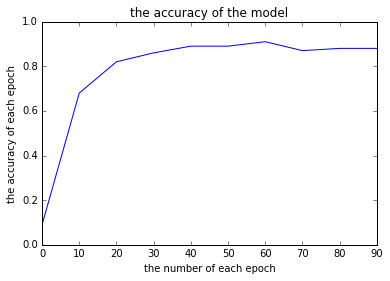

ending...
This whole code host 33 seconds...


SystemExit: 

d:\python\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
# import the related packages
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import sys
import time
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import ndimage
from six.moves import xrange
from scipy.misc import imsave
from six.moves import cPickle as pickle
from six.moves.urllib.request import urlretrieve

from notMnist_class import *

# define the changeable parameters
flags = tf.app.flags
flags.DEFINE_integer('max__steps', 100, 'the number of epoch')
flags.DEFINE_integer('dropout', 0.8, 'the value of the droup out')
flags.DEFINE_integer('learning__rate', 0.001, 'the learning rate of the model')
flags.DEFINE_string('optimizer', 'adam', 'the optimizer of the model')
flags.DEFINE_string('data__dir', '/input_data', 'the direction of the data')
flags.DEFINE_string('log__dir', 'D:/Data Minning/train_code/train/noMnist/model/', 'the direction the log file')
FLAGS = flags.FLAGS
 
def choose_optimizer(name):
    if name == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(FLAGS.learning__rate)
    elif name == 'adam':
        optimizer = tf.train.AdamOptimizer(FLAGS.learning__rate)
    elif name == 'adag':
        optimizer = tf.train.AdagradOptimizer(FLAGS.learning__rate)
    elif name == 'adad':
        optimizer = tf.train.AdadeltaOptimizer(FLAGS.learning__rate)
    elif name == 'rmsp':
        optimizer = tf.train.RMSPropOptimizer(FLAGS.learning__rate)
    else:
        print('please add you optimizer...')
        raise Exception('Error...')
    return optimizer


def train():
    start_time = time.time()
    
    np.random.seed(133)
    num_classes = 10          # The class of the directions      

    train_size = 200000       # The size of training datasets
    valid_size = 10000        # The size of validation datasets
    test_size = 10000         # The size of testing datasets
    
    image_size = 28           # Pixel width and height.
    pixel_depth = 255.0       # Number of levels per pixel.
    num_labels = 10           # The number of lables
    
    url = 'http://commondatastorage.googleapis.com/books1000/'
    last_percent_reported = None
    data_root = '.'           # Change me to store data elsewhere
    
    # Instance a object 
    notMnist_object  = notMnist(num_classes = 10, train_size = 200000, valid_size = 10000, test_size = 10000,
                                image_size = 28, pixel_depth = 255.0, num_labels = 10, last_percent_reported = None,
                                url = 'http://commondatastorage.googleapis.com/books1000/', data_root = '.')
    
    # Download the notMnist datasets(tar file)
    train_filename = notMnist_object.maybe_download('notMNIST_large.tar.gz', 247336696)
    test_filename = notMnist_object.maybe_download('notMNIST_small.tar.gz', 8458043)
    
    # Tar the file to the folders
    train_folders = notMnist_object.maybe_extract(train_filename)
    test_folders = notMnist_object.maybe_extract(test_filename)
    
    # Change the file to the pickle file
    train_datasets = notMnist_object.maybe_pickle(train_folders, 45000)
    test_datasets = notMnist_object.maybe_pickle(test_folders, 1800)     
           
    valid_dataset, valid_labels, train_dataset, train_labels = notMnist_object.merge_datasets(train_datasets, train_size, valid_size)
    _, _, test_dataset, test_labels = notMnist_object.merge_datasets(test_datasets, test_size)
    
    
    # Shuffer the datasets
    train_dataset, train_labels = notMnist_object.randomize(train_dataset, train_labels)
    test_dataset, test_labels = notMnist_object.randomize(test_dataset, test_labels)
    valid_dataset, valid_labels = notMnist_object.randomize(valid_dataset, valid_labels)
    
    # Save the pickle file and check it
    notMnist_object.save_pickle(train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels)
    
    # Change the format of the datasets
    train_dataset, train_labels = notMnist_object.reformat(train_dataset, train_labels)
    valid_dataset, valid_labels = notMnist_object.reformat(valid_dataset, valid_labels)
    test_dataset, test_labels = notMnist_object.reformat(test_dataset, test_labels)
    print('Training:', train_dataset.shape, train_labels.shape)
    print('Validation:', valid_dataset.shape, valid_labels.shape)
    print('Testing:', test_dataset.shape, test_labels.shape)
    
    # Create a Session layer
    sess = tf.InteractiveSession()

    # Input placeholders
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, 784], name='x_input')
        y_ = tf.placeholder(tf.float32, [None, 10], name='y_input')

    with tf.name_scope('input_reshape'):
        image = tf.reshape(x, [-1, 28, 28, 1])
        tf.summary.image('image', image, 10)
        
    hidden1 = notMnist_object.nn_layer(x, 784, 500, 'layer1')
    hidden2 = notMnist_object.nn_layer(hidden1, 500, 225, 'layer2')

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        tf.summary.scalar('druoput__keep_probability', keep_prob)
        dropped = tf.nn.dropout(hidden2, keep_prob)

    # Do not apply softmax activation yet, see below.
    y = notMnist_object.nn_layer(dropped, 225, 10, 'layer3', act=tf.identity)

    with tf.name_scope('cross_entropy'):
        diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
        with tf.name_scope('total'):
            cross_entropy = tf.reduce_mean(diff)
        tf.summary.scalar('cross_entropy', cross_entropy)

    with tf.name_scope('train'):
        train_step = choose_optimizer(name = FLAGS.optimizer).minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

    # Merge all the summaries and write them out to the log_dir
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.log__dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(FLAGS.log__dir + '/test')
    tf.global_variables_initializer().run()
             
    # Train the model, and also write summaries.
    # Every 10th step, measure test-set accuracy, and write test summaries
    # All other steps, run train_step on training data, & add training summaries

    def feed_dict(train):
        """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
        if train:
            xs, ys = notMnist_object.get_batch_data(data = train_dataset, label = train_labels, batch_size = 100)
            k = FLAGS.dropout
        else:
            xs, ys = notMnist_object.get_batch_data(data = test_dataset, label = test_labels, batch_size = 100)
            k = 1.0
        return {x: xs, y_: ys, keep_prob: k}
    
    accuracies = []
    epoch = []
    for i in xrange(FLAGS.max__steps):
        if i % 10 == 0:  
            # Record summaries and test-set accuracy
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('Accuracy at step %s: %s' % (i, acc))
            
            # Collect the accuracy and the number of epoch
            accuracies.append(acc)
            epoch.append(i)
            
        else:  
            # Record train set summaries, and train
            if i % 100 == 0:  
                # Record execution stats
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, _ = sess.run([merged, train_step],
                                      feed_dict=feed_dict(True),
                                      options=run_options,
                                      run_metadata=run_metadata)
                train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
                train_writer.add_summary(summary, i)
                print('Adding run metadata for', i)
            else:  
                # Record a summary
                summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
                train_writer.add_summary(summary, i)
    
    train_writer.close()
    test_writer.close()
    
    # Save the checkpoint file
    saver = tf.train.Saver()
    saver.save(sess, FLAGS.log__dir)
    
    # Plot the accuracy of the model
    plt.plot(epoch, accuracies)
    plt.xlabel('the number of each epoch')
    plt.ylabel('the accuracy of each epoch')
    plt.title('the accuracy of the model')
    plt.show()
    
    print('ending...')
    print('The whole compute host %d seconds...' %(time.time() - start_time))

def main(_):
    if tf.gfile.Exists(FLAGS.log__dir):
        tf.gfile.DeleteRecursively(FLAGS.log__dir)
    tf.gfile.MakeDirs(FLAGS.log__dir)
    train()

          
if __name__ == '__main__':
    tf.app.run()


Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz
.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']
.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_lar

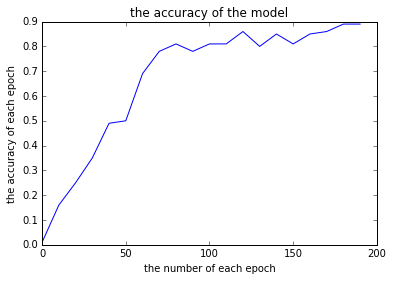

ending...
The whole compute host 65 seconds...


SystemExit: 

d:\python\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
# import the related packages
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import sys
import time
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import ndimage
from six.moves import xrange
from scipy.misc import imsave
from six.moves import cPickle as pickle
from six.moves.urllib.request import urlretrieve

from notMnist_class_cnn import *

# define the changeable parameters
flags = tf.app.flags
flags.DEFINE_integer('max__steps', 200, 'the number of epoch')
flags.DEFINE_integer('dropout', 0.8, 'the value of the droup out')
flags.DEFINE_integer('learning__rate', 0.001, 'the learning rate of the model')
flags.DEFINE_string('optimizer', 'adam', 'the optimizer of the model')
flags.DEFINE_string('data__dir', '/input_data', 'the direction of the data')
flags.DEFINE_string('log__dir', 'D:/Data Minning/train_code/train/noMnist/model/', 'the direction the log file')
FLAGS = flags.FLAGS
 
def choose_optimizer(name):
    if name == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(FLAGS.learning__rate)
    elif name == 'adam':
        optimizer = tf.train.AdamOptimizer(FLAGS.learning__rate)
    elif name == 'adag':
        optimizer = tf.train.AdagradOptimizer(FLAGS.learning__rate)
    elif name == 'adad':
        optimizer = tf.train.AdadeltaOptimizer(FLAGS.learning__rate)
    elif name == 'rmsp':
        optimizer = tf.train.RMSPropOptimizer(FLAGS.learning__rate)
    else:
        print('please add you optimizer...')
        raise Exception('Error...')
    return optimizer


def train():
    start_time = time.time()
    
    np.random.seed(133)
    num_classes = 10          # The class of the directions      

    train_size = 200000       # The size of training datasets
    valid_size = 10000        # The size of validation datasets
    test_size = 10000         # The size of testing datasets
    
    image_size = 28           # Pixel width and height.
    pixel_depth = 255.0       # Number of levels per pixel.
    num_labels = 10           # The number of lables
    
    depth = 16                # The depth of each layer
    batch_size = 16           # The batch size of each layer
    patch_size = 5            # The filter ize of each layer
    num_hidden = 64           # The size of hidden layer
    num_channels = 1          # The channel of image
    
    url = 'http://commondatastorage.googleapis.com/books1000/'
    last_percent_reported = None
    data_root = '.'           # Change me to store data elsewhere
    
    # Instance a object 
    notMnist_object  = notMnist(num_classes = 10, train_size = 200000, valid_size = 10000, test_size = 10000,
                                image_size = 28, pixel_depth = 255.0, num_labels = 10, last_percent_reported = None,
                                url = 'http://commondatastorage.googleapis.com/books1000/', data_root = '.')
    
    # Download the notMnist datasets(tar file)
    train_filename = notMnist_object.maybe_download('notMNIST_large.tar.gz', 247336696)
    test_filename = notMnist_object.maybe_download('notMNIST_small.tar.gz', 8458043)
    
    # Tar the file to the folders
    train_folders = notMnist_object.maybe_extract(train_filename)
    test_folders = notMnist_object.maybe_extract(test_filename)
    
    # Change the file to the pickle file
    train_datasets = notMnist_object.maybe_pickle(train_folders, 45000)
    test_datasets = notMnist_object.maybe_pickle(test_folders, 1800)     
           
    valid_dataset, valid_labels, train_dataset, train_labels = notMnist_object.merge_datasets(train_datasets, train_size, valid_size)
    _, _, test_dataset, test_labels = notMnist_object.merge_datasets(test_datasets, test_size)
    
    
    # Shuffer the datasets
    train_dataset, train_labels = notMnist_object.randomize(train_dataset, train_labels)
    test_dataset, test_labels = notMnist_object.randomize(test_dataset, test_labels)
    valid_dataset, valid_labels = notMnist_object.randomize(valid_dataset, valid_labels)
    
    # Save the pickle file and check it
    notMnist_object.save_pickle(train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels)
    
    # Change the format of the datasets
    train_dataset, train_labels = notMnist_object.reformat(train_dataset, train_labels)
    valid_dataset, valid_labels = notMnist_object.reformat(valid_dataset, valid_labels)
    test_dataset, test_labels = notMnist_object.reformat(test_dataset, test_labels)
    print('Training:', train_dataset.shape, train_labels.shape)
    print('Validation:', valid_dataset.shape, valid_labels.shape)
    print('Testing:', test_dataset.shape, test_labels.shape)
    
    # Create a Session layer
    sess = tf.InteractiveSession()

    # Input placeholders
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, 784], name='x_input')
        y_ = tf.placeholder(tf.float32, [None, 10], name='y_input')

    with tf.name_scope('input_reshape'):
        image = tf.reshape(x, [-1, 28, 28, 1])
        tf.summary.image('image', image, 10)
    
    weights1, weights2, weights3, weights4, biases1, biases2, biases3, biases4 = notMnist_object.layer_weights(
                                  patch_size = patch_size, num_channels = num_channels, depth = depth, 
                                  image_size = image_size, num_hidden = num_hidden, num_labels = num_labels)
    
    y = notMnist_object.notMnist_CNN(data = image, weights1  = weights1 , weights2 = weights2, weights3 = weights3, 
                                     weights4 = weights4, biases1 = biases1, biases2 = biases2, biases3 = biases3, 
                                     biases4 = biases4)
    
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        tf.summary.scalar('druoput__keep_probability', keep_prob)
        
    with tf.name_scope('cross_entropy'):
        diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
        with tf.name_scope('total'):
            cross_entropy = tf.reduce_mean(diff)
        tf.summary.scalar('cross_entropy', cross_entropy)

    with tf.name_scope('train'):
        train_step = choose_optimizer(name = FLAGS.optimizer).minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

    # Merge all the summaries and write them out to the log_dir
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.log__dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(FLAGS.log__dir + '/test')
    tf.global_variables_initializer().run()
             
    # Train the model, and also write summaries.
    # Every 10th step, measure test-set accuracy, and write test summaries
    # All other steps, run train_step on training data, & add training summaries

    def feed_dict(train):
        """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
        if train:
            xs, ys = notMnist_object.get_batch_data(data = train_dataset, label = train_labels, batch_size = 100)
            k = FLAGS.dropout
        else:
            xs, ys = notMnist_object.get_batch_data(data = test_dataset, label = test_labels, batch_size = 100)
            k = 1.0
        return {x: xs, y_: ys, keep_prob: k}
    
    accuracies = []
    epoch = []
    for i in xrange(FLAGS.max__steps):
        if i % 10 == 0:  
            # Record summaries and test-set accuracy
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('Accuracy at step %s: %s' % (i, acc))
            
            # Collect the accuracy and the number of epoch
            accuracies.append(acc)
            epoch.append(i)
            
        else:  
            # Record train set summaries, and train
            if i % 100 == 0:  
                # Record execution stats
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, _ = sess.run([merged, train_step],
                                      feed_dict=feed_dict(True),
                                      options=run_options,
                                      run_metadata=run_metadata)
                train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
                train_writer.add_summary(summary, i)
                print('Adding run metadata for', i)
            else:  
                # Record a summary
                summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
                train_writer.add_summary(summary, i)
    
    train_writer.close()
    test_writer.close()
    
    # Save the checkpoint file
    saver = tf.train.Saver()
    saver.save(sess, FLAGS.log__dir)
    
    # Plot the accuracy of the model
    plt.plot(epoch, accuracies)
    plt.xlabel('the number of each epoch')
    plt.ylabel('the accuracy of each epoch')
    plt.title('the accuracy of the model')
    plt.show()
    
    print('ending...')
    print('The whole compute host %d seconds...' %(time.time() - start_time))

def main(_):
    if tf.gfile.Exists(FLAGS.log__dir):
        tf.gfile.DeleteRecursively(FLAGS.log__dir)
    tf.gfile.MakeDirs(FLAGS.log__dir)
    train()

          
if __name__ == '__main__':
    tf.app.run()


In [ ]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import sys
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import ndimage
from six.moves import xrange
from scipy.misc import imsave
from six.moves import cPickle as pickle
from IPython.display import display, Image
from six.moves.urllib.request import urlretrieve

class notMnist(object):
    def __init__(self, num_classes, train_size, valid_size, test_size, image_size, 
                 pixel_depth, num_labels, url, last_percent_reported, data_root):
        self.num_classes = num_classes
        self.train_size = train_size
        self.valid_size = valid_size
        self.test_size = test_size
        self.image_size = image_size
        self.pixel_depth = pixel_depth
        self.num_labels = num_labels
        self.url = url
        self.last_percent_reported = last_percent_reported
        self.data_root = data_root
        
        # define some funtion to sample the code
    def download_progress_hook(self, count, blockSize, totalSize):
        """A hook to report the progress of a download. This is mostly intended for users with
        slow internet connections. Reports every 5% change in download progress.
        """
        #global last_percent_reported
        percent = int(count * blockSize * 100 / totalSize)

        if self.last_percent_reported != percent:
            if percent % 5 == 0:
                sys.stdout.write("%s%%" % percent)
                sys.stdout.flush()
            else:
                sys.stdout.write(".")
                sys.stdout.flush()
      
        self.last_percent_reported = percent
    
    def maybe_download(self, filename, expected_bytes, force=False):
        """Download a file if not present, and make sure it's the right size."""
        dest_filename = os.path.join(self.data_root, filename)
        if force or not os.path.exists(dest_filename):
            print('Attempting to download:', filename) 
            filename, _ = urlretrieve(self.url + filename, dest_filename, reporthook=download_progress_hook)
            print('\nDownload Complete!')
        statinfo = os.stat(dest_filename)
        if statinfo.st_size == expected_bytes:
            print('Found and verified', dest_filename)
        else:
            raise Exception( 'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
        return dest_filename

    def maybe_extract(self, filename, force=False):
        root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
        if os.path.isdir(root) and not force:
        # You may override by setting force=True.
            print('%s already present - Skipping extraction of %s.' % (root, filename))
        else:
            print('Extracting data for %s. This may take a while. Please wait.' % root)
            tar = tarfile.open(filename)
            sys.stdout.flush()
            tar.extractall(self.data_root)
            tar.close()
        data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
        if len(data_folders) != self.num_classes:
            raise Exception( 'Expected %d folders, one per class. Found %d instead.' 
                            % (self.num_classes, len(data_folders)))
        print(data_folders)
        return data_folders


    def make_arrays(self, nb_rows, img_size):
        """Change the data and lables to the arrays """
        if nb_rows:
            dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
            label = np.ndarray(nb_rows, dtype=np.int32)
        else:
            dataset, label = None, None
        return dataset, label
    
    def merge_datasets(self, pickle_files, train_size, valid_size=0):
        num_classes = len(pickle_files)
        valid_dataset, valid_labels = self.make_arrays(valid_size, self.image_size)
        train_dataset, train_labels = self.make_arrays(train_size, self.image_size)
        vsize_per_class = valid_size // self.num_classes
        tsize_per_class = train_size // self.num_classes
    
        start_v, start_t = 0, 0
        end_v, end_t = vsize_per_class, tsize_per_class
        end_l = vsize_per_class+tsize_per_class
        for label, pickle_file in enumerate(pickle_files):       
            try:
                with open(pickle_file, 'rb') as f:
                    letter_set = pickle.load(f)
                    np.random.shuffle(letter_set)
                    if valid_dataset is not None:
                        valid_letter = letter_set[:vsize_per_class, :, :]
                        valid_dataset[start_v:end_v, :, :] = valid_letter
                        valid_labels[start_v:end_v] = label
                        start_v += vsize_per_class
                        end_v += vsize_per_class
                    
                    train_letter = letter_set[vsize_per_class:end_l, :, :]
                    train_dataset[start_t:end_t, :, :] = train_letter
                    train_labels[start_t:end_t] = label
                    start_t += tsize_per_class
                    end_t += tsize_per_class
            except Exception as e:
                print('Unable to process data from', pickle_file, ':', e)
                raise
    
        return valid_dataset, valid_labels, train_dataset, train_labels

    def load_letter(self, folder, min_num_images):
        """Load the data for a single letter label."""
        image_files = os.listdir(folder)
        dataset = np.ndarray(shape=(len(image_files), self.image_size, self.image_size),dtype=np.float32)
        print(folder)
        num_images = 0
        for image in image_files:
            image_file = os.path.join(folder, image)
            try:
                image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
                if image_data.shape != (self.image_size, self.image_size):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[num_images, :, :] = image_data
                num_images = num_images + 1
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
        dataset = dataset[0:num_images, :, :]
        if num_images < min_num_images:
            raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
        print('Full dataset tensor:', dataset.shape)
        print('Mean:', np.mean(dataset))
        print('Standard deviation:', np.std(dataset))
        return dataset

    def maybe_pickle(self, data_folders, min_num_images_per_class, force=False):
        """Check the pickle file and load the pictures"""
        dataset_names = []
        for folder in data_folders:
            set_filename = folder + '.pickle'
            dataset_names.append(set_filename)
            if os.path.exists(set_filename) and not force:
                # You may override by setting force=True.
                print('%s already present - Skipping pickling.' % set_filename)
            else:
                print('Pickling %s.' % set_filename)
                dataset = load_letter(folder, min_num_images_per_class)
                try:
                    with open(set_filename, 'wb') as f:
                        pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
                except Exception as e:
                    print('Unable to save data to', set_filename, ':', e)
  
        return dataset_names

    def save_pickle(self, train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels):
        pickle_file = os.path.join(self.data_root, 'notMNIST.pickle')

        try:
            f = open(pickle_file, 'wb')
            save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
            }
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise
    
        statinfo = os.stat(pickle_file)
        print('Compressed pickle size:', statinfo.st_size)

    def randomize(self, dataset, labels):
        """Random the datas and the lables"""
        permutation = np.random.permutation(labels.shape[0])
        shuffled_dataset = dataset[permutation,:,:]
        shuffled_labels = labels[permutation]
        return shuffled_dataset, shuffled_labels
    
    def reformat(self, dataset, lables):
        """Change the shape of the datasets and lables"""
        dataset = dataset.reshape((-1, self.image_size * self.image_size)).astype(np.float32)
        lables = (np.arange(self.num_labels) == lables[:,None]).astype(np.float32)
        return dataset, lables
    
    # We can't initialize these variables to 0 - the network will get stuck.
    def weight_variable(self, shape):
        """Create a weight variable with appropriate initialization."""
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(self, shape, value):
        """Create a bias variable with appropriate initialization."""
        initial = tf.constant(value, shape=shape)
        return tf.Variable(initial)

    def variable_summaries(self, var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
    # Define the weights and the biases of the layers 
    def layer_weights(self, patch_size, num_channels, depth, image_size, num_hidden, num_labels):
        with tf.name_scope('layer1'):
            weights1 = self.weight_variable([patch_size, patch_size, num_channels, depth])
            biases1 = self.bias_variable([depth], value = 0.0)
            self.variable_summaries(weights1)
            self.variable_summaries(biases1)
        
        with tf.name_scope('layer2'):
            weights2 = self.weight_variable([patch_size, patch_size, depth, depth])
            biases2 = self.bias_variable([depth], value = 1.0)
            self.variable_summaries(weights2)
            self.variable_summaries(biases2)
        
        with tf.name_scope('layer3'):
            weights3 = self.weight_variable([image_size // 4 * image_size // 4 * depth, num_hidden])
            biases3 = self.bias_variable([num_hidden], value = 1.0)
            self.variable_summaries(weights3)
            self.variable_summaries(biases3)
        
        with tf.name_scope('layer4'):
            weights4 = self.weight_variable([num_hidden, num_labels])
            biases4 = self.bias_variable([num_labels], value = 1.0)
            self.variable_summaries(weights4)
            self.variable_summaries(biases4)
        return weights1, weights2, weights3, weights4, biases1, biases2, biases3, biases4
    
    # Build the CNN model
    def notMnist_CNN(self, data, weights1, weights2, weights3, weights4, biases1, biases2, biases3, biases4):
        conv = tf.nn.conv2d(data, weights1, [1, 1, 1, 1], padding='SAME')
        pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(pool + biases1)

        conv = tf.nn.conv2d(hidden, weights2, [1, 1, 1, 1], padding='SAME')
        pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(pool + biases2)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [-1, shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, weights3) + biases3)
        drop = tf.nn.dropout(hidden, 1)

        output_layer = tf.matmul(drop, weights4) + biases4
        return output_layer
    
 
    def get_batch_data(self, data,label,batch_size):
        """Get the batch datas and the lables"""
        start_index = np.random.randint(0, len(data) - batch_size)
        return data[start_index : start_index + batch_size], label[start_index : start_index + batch_size]
        
    

In [2]:
from scipy.misc import imsave

In [2]:
help(imsave)

Help on function imsave in module scipy.misc.pilutil:

imsave(name, arr, format=None)
    Save an array as an image.
    
    Parameters
    ----------
    name : str or file object
        Output file name or file object.
    arr : ndarray, MxN or MxNx3 or MxNx4
        Array containing image values.  If the shape is ``MxN``, the array
        represents a grey-level image.  Shape ``MxNx3`` stores the red, green
        and blue bands along the last dimension.  An alpha layer may be
        included, specified as the last colour band of an ``MxNx4`` array.
    format : str
        Image format. If omitted, the format to use is determined from the
        file name extension. If a file object was used instead of a file name,
        this parameter should always be used.
    
    Examples
    --------
    Construct an array of gradient intensity values and save to file:
    
    >>> from scipy.misc import imsave
    >>> x = np.zeros((255, 255))
    >>> x = np.zeros((255, 255), dtype=np.

In [2]:
help(tf.reshape)

Help on function reshape in module tensorflow.python.ops.gen_array_ops:

reshape(tensor, shape, name=None)
    Reshapes a tensor.
    
    Given `tensor`, this operation returns a tensor that has the same values
    as `tensor` with shape `shape`.
    
    If one component of `shape` is the special value -1, the size of that dimension
    is computed so that the total size remains constant.  In particular, a `shape`
    of `[-1]` flattens into 1-D.  At most one component of `shape` can be -1.
    
    If `shape` is 1-D or higher, then the operation returns a tensor with shape
    `shape` filled with the values of `tensor`. In this case, the number of elements
    implied by `shape` must be the same as the number of elements in `tensor`.
    
    For example:
    
    ```prettyprint
    # tensor 't' is [1, 2, 3, 4, 5, 6, 7, 8, 9]
    # tensor 't' has shape [9]
    reshape(t, [3, 3]) ==> [[1, 2, 3],
                            [4, 5, 6],
                            [7, 8, 9]]
    
    # 